# Person Detection in COCO and Styled COCO Datasets

In this notebook we show how to use a person detection neural network to detect the persons in the images from the COCO
and Styled COCO datasets. In particular, we use a Faster-RCNN model trained on the standard COCO dataset to extract the humans in 
both our datasets.

Spoiler alert, we show how the Faster-RCNN performs very well for the original COCO images whereas it does not generalize to the styled COCO dataset. 
It is of paramount importance for our taks to have an accurate person detector, since the pose estimation model only receives the persons estimaded by the detector.

In [1]:
import os
import sys

import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.append("..")

import torchvision
import data

import data.data_processing as data_processing
import lib.utils as utils
import lib.bounding_box as bbox_lib
import lib.visualizations as visualizations
from lib.transforms import unnormalize, prepare_image_detector
from CONFIG import CONFIG
import CONSTANTS

In [2]:
exp_name = os.path.join("notebook_tests", "hrnet_notebook")
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
data_path = CONFIG["paths"]["data_path"]
imgs_path = os.path.join(data_path, "images", "validation")
original_imgs_path = os.path.join(data_path, "original_images", "val2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")

In [3]:
%reload_ext autoreload
%autoreload 2

# Loading Images

Loading an original image from the COCO dataset and its styled counterpart

In [4]:
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["dataset"]["dataset_name"] = "styled_coco"

In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(
    mean=mean.tolist(), std=std.tolist()
)

In [6]:
hrnet_dataset = data.HRNetCoco(exp_data=exp_data, root=data_path, img_path=imgs_path,
                               labels_path=labels_file, is_train=False,
                               is_styled=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   normalize,
                               ]))

Loading /home/corrales/MasterThesis/data/mapping_dicts/valid_dict.json...
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [7]:
# sampling random image from the dataset
image_idx = np.random.randint(low=0, high=len(hrnet_dataset))
image_name = hrnet_dataset.get_name_given_id(image_idx)
print(f"ID: {image_idx}  --  Image: {image_name}")

# sampling a person-crop and the annotatios  
imgs, target, target_weight, metadata = hrnet_dataset.get_all_samples_given_name(image_name)

n_humans = imgs.shape[0]
print(f"N People: {n_humans}")
full_img_path = metadata["image"][0]
full_img = cv2.imread(full_img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)

ID: 2174  --  Image: 000000530162_stylized_hoplit.jpg
N People: 8


In [8]:
img_path = metadata["image"][0]
styled_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
styled_img = cv2.cvtColor(styled_img, cv2.COLOR_RGB2BGR)

original_img_path = metadata["original_image"][0]
original_img_path = os.path.join(original_imgs_path, original_img_path.split("/")[-1])
original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)

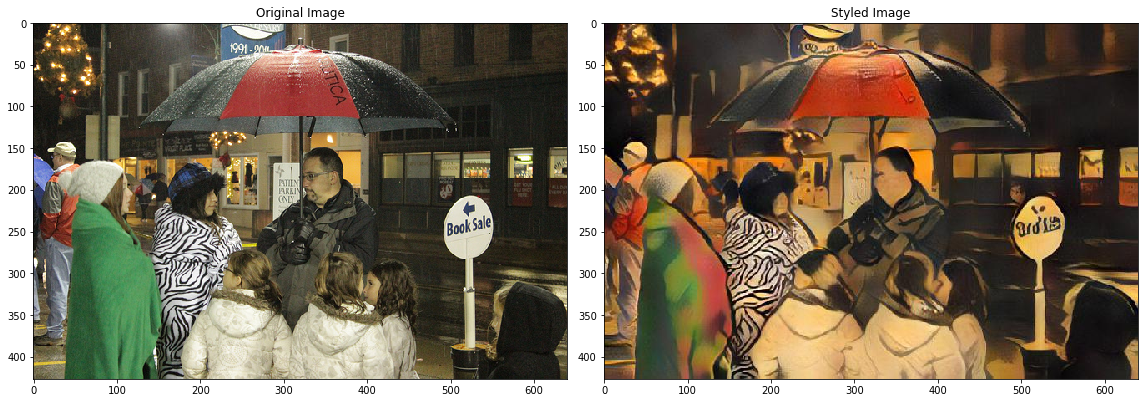

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 6)
ax[0].imshow(original_img)
ax[0].set_title("Original Image")
ax[1].imshow(styled_img)
ax[1].set_title("Styled Image")
plt.tight_layout()
plt.show()

# Person Detector Model

Loading the Faster-RCNN model provided by Torchvision. This model has been trained on the COCO dataset, but it has not yet seen styled images.
For this reason, the model does fully generalize to our Styled COCO dataset. Therefore, the model must be retrained/fine-tune before 
using it in the pose-based retrieval pipeline.

In [10]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
faster_rcnn = faster_rcnn.to(device)
faster_rcnn = faster_rcnn.eval()

# Inference

Let's now try out the model on both images.

In [13]:
in_original_img = prepare_image_detector(original_img)
in_styled_img = prepare_image_detector(styled_img)

In [14]:
original_preds = faster_rcnn((in_original_img).float())
original_boxes, original_labels, original_scores = bbox_lib.bbox_filtering(original_preds, filter=1)

styled_preds = faster_rcnn((in_styled_img).float())
styled_boxes, styled_labels, styled_scores = bbox_lib.bbox_filtering(styled_preds, filter=1)

In [16]:
print("Original Image Predictions")
for i, box in enumerate(original_boxes[0]):
    print(f"{box}  {original_labels[0][i]}  {original_scores[0][i]}")

print("\nStyled Image Predictions")
for i, box in enumerate(styled_boxes[0]):
    print(f"{box}  {styled_labels[0][i]}  {styled_scores[0][i]}")

Original Image Predictions
[181.61488, 268.09998, 311.87234, 424.2964]  1  0.9951969981193542
[16.89247, 159.54678, 155.15112, 421.20663]  1  0.9949618577957153
[139.61116, 163.12514, 258.2069, 425.84604]  1  0.9943645000457764
[6.996054, 140.01788, 55.931805, 389.53937]  1  0.9909150004386902
[268.071, 149.50163, 413.95215, 359.73203]  1  0.9853412508964539
[305.31662, 271.81512, 436.61185, 421.29892]  1  0.984219491481781
[397.17688, 284.41937, 464.55658, 425.1861]  1  0.9818431735038757
[121.448845, 191.1034, 140.60667, 240.02391]  1  0.8495026230812073
[237.54594, 178.9417, 246.88358, 199.43213]  1  0.7309243679046631
[541.382, 308.30847, 637.6807, 424.18878]  1  0.7171264886856079
[140.38466, 185.27486, 163.39896, 238.41702]  1  0.6448244452476501
[253.57677, 168.84761, 263.78516, 198.49722]  1  0.6172388792037964

Styled Image Predictions
[219.77718, 155.00873, 460.97687, 410.6858]  1  0.9762532114982605
[259.66464, 151.16905, 416.77682, 345.57944]  1  0.8156059980392456
[485.494

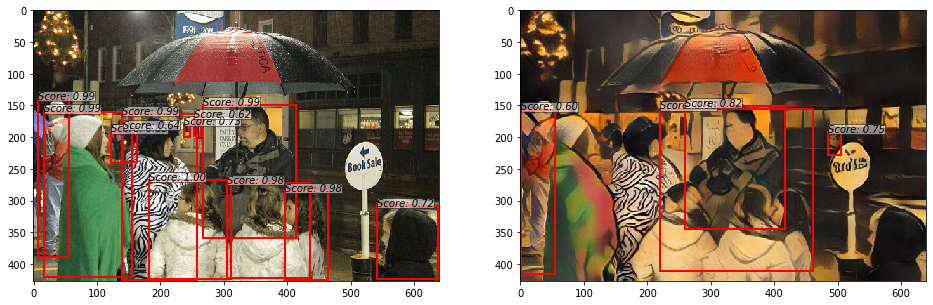

In [17]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 6)

visualizations.visualize_bbox(original_img, boxes=original_boxes[0], labels=original_labels[0],
                              scores=original_scores[0], ax=ax[0])
visualizations.visualize_bbox(styled_img, boxes=styled_boxes[0], labels=styled_labels[0],
                              scores=styled_scores[0], ax=ax[1])

plt.show()

# References

**[1]** Ren, Shaoqing, et al. *Faster r-cnn: Towards real-time object detection with region proposal networks.* Advances in neural information processing systems. 2015.

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 